In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.datasets import load_boston
from sklearn.preprocessing import scale

In [2]:
def data_segmentation(data_path, target_path, task):
    # task = 0 >> select the name ID targets for face recognition task
    # task = 1 >> select the gender ID targets for gender recognition task
    data = np.load(data_path)/255
    data = np.reshape(data, [-1, 32*32])
    target = np.load(target_path)
    np.random.seed(45689)
    rnd_idx = np.arange(np.shape(data)[0])
    np.random.shuffle(rnd_idx)
    trBatch = int(0.8*len(rnd_idx))
    validBatch = int(0.1*len(rnd_idx))
    trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
    data[rnd_idx[trBatch+1:trBatch + validBatch],:],\
    data[rnd_idx[trBatch + validBatch+1:-1],:]
    trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
    target[rnd_idx[trBatch+1:trBatch + validBatch], task],\
    target[rnd_idx[trBatch + validBatch + 1:-1], task]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [3]:
trainData, validData, testData, trainTarget, validTarget, testTarget = data_segmentation('data.npy', 'target.npy', 0)

trainTarget=np.expand_dims(trainTarget, 1)
validTarget=np.expand_dims(validTarget, 1)
testTarget=np.expand_dims(testTarget, 1)

print(trainData.shape)
print(trainTarget.shape)


(747, 1024)
(747, 1)


In [4]:
def logistic_regression_Adam(decay_lambda, iterations, mini_batch_size, learning_rate, num_classes):
    num_features=trainData.shape[1]
    
    X = tf.placeholder(dtype=tf.float64,shape=[None, num_features])
    Y = tf.placeholder(dtype=tf.int64,shape=[None, 1])
    
    W = tf.Variable(tf.zeros(dtype=tf.float64, shape=[num_features, num_classes]))
    b = tf.Variable(tf.zeros(dtype=tf.float64, shape=[num_classes]))
    
    #actual labels in one-hot vector form
    true_Y = tf.one_hot(Y, depth = num_classes)
    
    pred_Y = tf.matmul(X,W)+b
    
    Loss_D = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_Y,logits=pred_Y))
    Loss_W = 0.5*decay_lambda*tf.reduce_sum(tf.square(W))
    total_loss = Loss_D + Loss_W
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    train_set_size = trainData.shape[0]
    n_batch = train_set_size // mini_batch_size + (train_set_size % mini_batch_size != 0)
    init = tf.global_variables_initializer()
    
    #define an accuracy op for validation accuracy rate
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(Y), tf.argmax(pred_Y, axis=1)), tf.float64))
    
    with tf.Session() as sess:
        epoch_trace = []
        training_loss_trace = []
        training_accuracy_trace = []
        validation_loss_trace = []
        validation_accuracy_trace = []
        
        sess.run(init)
        
        for step in range(iterations):
            i_batch = (step%n_batch)*mini_batch_size
            xs = trainData[i_batch:i_batch+mini_batch_size]
            ys = trainTarget[i_batch:i_batch+mini_batch_size]
            
            Validation_Cost = sess.run(total_loss, feed_dict={X:validData, Y:validTarget})
            Validation_Accuracy = sess.run(accuracy, feed_dict={X:validData, Y:validTarget})
            
            Training_Cost = sess.run(total_loss, feed_dict={X:xs, Y:ys})
            Training_Accuracy = sess.run(accuracy, feed_dict={X:xs, Y:ys})
            
            sess.run(optimizer, feed_dict={X:xs, Y:ys})
            
            if(step%n_batch==0):
                epoch_number = step/n_batch
                epoch_trace.append(epoch_number)
                training_loss_trace.append(Training_Cost)
                training_accuracy_trace.append(Training_Accuracy)
                validation_loss_trace.append(Validation_Cost)
                validation_accuracy_trace.append(Validation_Accuracy)
                
    
        # Accuracy Rate for Validation Set
        output_str = "When weight decay coefficient = {}, " \
                     + "total iterations = {}, " \
                     + "mini_batch_size = {}, " \
                     + "learning rate = {}, " \
                     + "and total number of classes = {}:\n" \
                     + "the Accuracy Rate for Training Set is {:.6f} after training is finished.\n" \
                     + "The Accuracy Rate for Validation Set is {:.6f}.\n" \
                     + "The Accuracy Rate for Test Set is {:.6f}.\n" \
                     + "\n"
        train_accu = sess.run(accuracy, feed_dict={X:trainData, Y:trainTarget})
        valid_accu = sess.run(accuracy, feed_dict={X:validData, Y:validTarget})
        test_accu = sess.run(accuracy, feed_dict={X:testData, Y:testTarget})
        print(output_str.format(decay_lambda, iterations, mini_batch_size, learning_rate, \
              num_classes, train_accu, valid_accu, test_accu))
               
    return epoch_trace,training_loss_trace, training_accuracy_trace, \
            validation_loss_trace, validation_accuracy_trace

When weight decay coefficient = 0.01, total iterations = 5000, mini_batch_size = 300, learning rate = 0.001, and total number of classes = 6:
the Accuracy Rate for Training Set is 0.922356 after training is finished.
The Accuracy Rate for Validation Set is 0.858696.
The Accuracy Rate for Test Set is 0.881720.




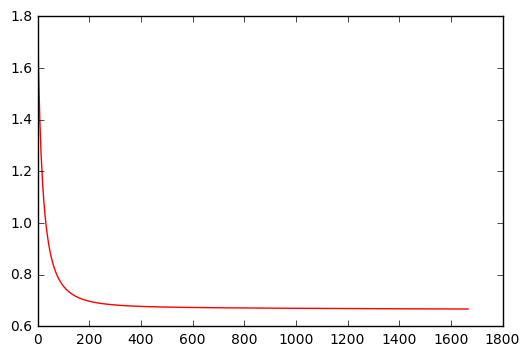

In [12]:
points0 = logistic_regression_Adam(decay_lambda=0.01, iterations=5000, mini_batch_size=300, learning_rate=0.001, num_classes=6)
plt.plot(points0[0], points0[1], 'r')

plt.show()

In [13]:
points1 = logistic_regression_Adam(decay_lambda=0.0, iterations=5000, mini_batch_size=300, learning_rate=0.001, num_classes=6)
points2 = logistic_regression_Adam(decay_lambda=0.1, iterations=5000, mini_batch_size=300, learning_rate=0.001, num_classes=6)

When weight decay coefficient = 0.0, total iterations = 5000, mini_batch_size = 300, learning rate = 0.001, and total number of classes = 6:
the Accuracy Rate for Training Set is 1.000000 after training is finished.
The Accuracy Rate for Validation Set is 0.836957.
The Accuracy Rate for Test Set is 0.870968.


When weight decay coefficient = 0.1, total iterations = 5000, mini_batch_size = 300, learning rate = 0.001, and total number of classes = 6:
the Accuracy Rate for Training Set is 0.792503 after training is finished.
The Accuracy Rate for Validation Set is 0.804348.
The Accuracy Rate for Test Set is 0.763441.




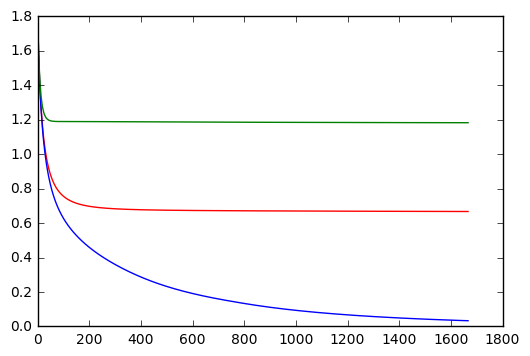

In [14]:
plt.plot(points0[0], points0[1], 'r')
plt.plot(points1[0], points1[1], 'b')
plt.plot(points2[0], points2[1], 'g')


plt.show()

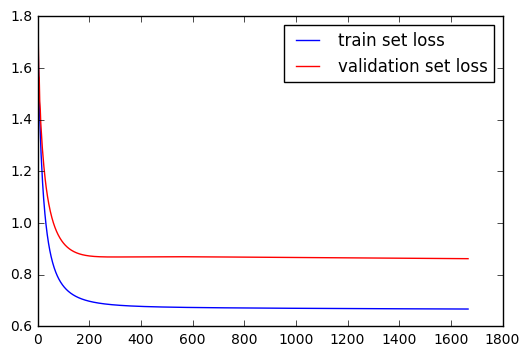

In [17]:
plt.plot(points0[0], points0[1], 'b', label='train set loss')
plt.plot(points0[0], points0[3], 'r', label='validation set loss')
plt.legend()
plt.show()


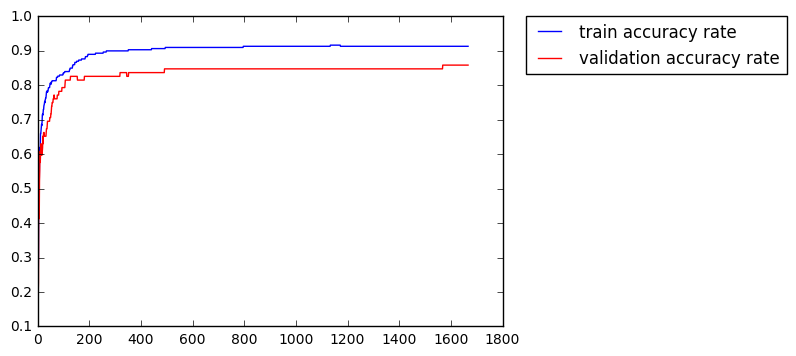

In [19]:
plt.plot(points0[0], points0[2], 'b', label='train accuracy rate')
plt.plot(points0[0], points0[4], 'r', label='validation accuracy rate')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()